In [3]:
import boto3
from boto3.dynamodb.conditions import Key
import pandas as pd
dynamodb = boto3.resource('dynamodb')

table = dynamodb.Table('heating_oil_prices')
response = table.scan()
df = pd.DataFrame(response["Items"])
df.to_csv("data.csv")

In [200]:
df = pd.read_csv("data.csv", usecols=["last_updated", "price150","price500", "price300", "supplier", "state"])
df["last_updated"] = pd.to_datetime(df["last_updated"])
df = df.set_index("last_updated")
df["state"] = df["state"].apply(lambda x: "NewYork" if str(x) == "nan" else x)
df = df.sort_index()

In [201]:
len(df)

6513

In [202]:
state = "NewYork"
df = df.reset_index()
data = df[ df["state"] == state].resample('d', on='last_updated').mean().dropna()
data = data.reset_index()

In [203]:
data.head()

,last_updated,price500,price300,price150
0,2020-08-03,1.633600,1.681167,1.731167
1,2020-08-04,1.605111,1.612500,1.685500
2,2020-10-29,1.820364,1.795250,1.831833
3,2020-11-11,1.733000,1.727500,1.760833
4,2020-11-12,1.420000,1.460000,1.540000


<AxesSubplot:>

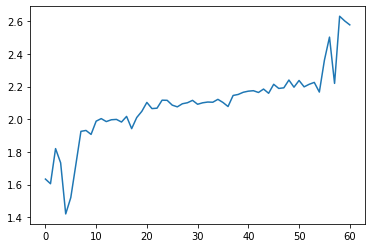

In [204]:
# import pycaret
# from pycaret.regression import *

data["price500"].plot()


In [205]:
from fastai.tabular.all import *
add_datepart(data, field_name="last_updated")

,price500,price300,price150,last_updatedYear,last_updatedMonth,last_updatedWeek,last_updatedDay,last_updatedDayofweek,last_updatedDayofyear,last_updatedIs_month_end,last_updatedIs_month_start,last_updatedIs_quarter_end,last_updatedIs_quarter_start,last_updatedIs_year_end,last_updatedIs_year_start,last_updatedElapsed
0,1.633600,1.681167,1.731167,2020,8,32,3,0,216,False,False,False,False,False,False,1.596413e+09
1,1.605111,1.612500,1.685500,2020,8,32,4,1,217,False,False,False,False,False,False,1.596499e+09
2,1.820364,1.795250,1.831833,2020,10,44,29,3,303,False,False,False,False,False,False,1.603930e+09
3,1.733000,1.727500,1.760833,2020,11,46,11,2,316,False,False,False,False,False,False,1.605053e+09
4,1.420000,1.460000,1.540000,2020,11,46,12,3,317,False,False,False,False,False,False,1.605139e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,2.503600,2.456333,2.486333,2021,4,15,16,4,106,False,False,False,False,False,False,1.618531e+09
57,2.220000,2.260000,2.340000,2021,6,26,28,0,179,False,False,False,False,False,False,1.624838e+09
58,2.631545,2.628857,2.648857,2021,7,26,2,4,183,False,False,False,False,False,False,1.625184e+09
59,2.602725,2.583241,2.608561,2021,7,27,5,0,186,False,False,False,False,False,False,1.625443e+09


In [220]:
mask = round(len(data) * 0.7)
train = data[:mask]
test = data[mask:]
train.shape, test.shape

((43, 16), (18, 16))

In [226]:
# import the regression module
from pycaret.regression import *
# initialize setup
s = setup(data = train, test_data = test, target = 'price500', fold_strategy = 'timeseries', numeric_features = ['last_updatedYear','last_updatedMonth', 'last_updatedDay'], fold = 3, transform_target = True, session_id = 42)

,Description,Value
0,session_id,42
1,Target,price500
2,Original Data,"(43, 16)"
3,Missing Values,False
4,Numeric Features,7
5,Categorical Features,8
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(43, 23)"


In [227]:
best = compare_models(sort = 'MAE')

IntProgress(value=0, description='Processing: ', max=99)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,14:54:14
Status,. . . . . . . . . . . . . . . . . .,Compiling Final Models
Estimator,. . . . . . . . . . . . . . . . . .,Extreme Gradient Boosting


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
xgboost,Extreme Gradient Boosting,0.0304,0.0015,0.0367,-0.6029,0.0119,0.0145,0.1300
dt,Decision Tree Regressor,0.0330,0.0019,0.0411,-1.2463,0.0134,0.0157,0.4867
gbr,Gradient Boosting Regressor,0.0335,0.0017,0.0401,-1.5566,0.0130,0.0160,0.0267
omp,Orthogonal Matching Pursuit,0.0338,0.0017,0.0406,-4.2560,0.0132,0.0161,0.5033
ada,AdaBoost Regressor,0.0411,0.0024,0.0485,-3.5959,0.0158,0.0196,0.0400
rf,Random Forest Regressor,0.0441,0.0028,0.0512,-3.7594,0.0167,0.0210,0.1767
knn,K Neighbors Regressor,0.0479,0.0032,0.0547,-4.1807,0.0178,0.0229,0.5367
catboost,CatBoost Regressor,0.0662,0.0063,0.0773,-10.9459,0.0254,0.0317,0.2267
lr,Linear Regression,0.0687,0.0093,0.0858,-25.3388,0.0287,0.0332,1.2200
par,Passive Aggressive Regressor,0.0787,0.0096,0.0844,-10.8717,0.0276,0.0371,0.0167


In [ ]:
https://stackoverflow.com/questions/44937698/lightgbm-oserror-library-not-loaded
https://github.com/microsoft/LightGBM/issues/1369